# <center>Varun_Kumar(142002018)</center>

## <center>SELF DRIVING CAR</center>

## 1.Importing libraries

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import pi
from itertools import islice
import cv2
import tensorflow as tf
import pickle

## 2.Reading images names from text file

In [3]:
#reading the data set from data.txt

dataset_path = 'driving_dataset/'
training_path = os.path.join( 'data.txt')

split = 0.8
X = []
y = []

#islice(text, start, stop, LIMIT) --> ('ABCDEF', 2, None) --> 'C D E F'  -->https://docs.python.org/2/library/itertools.html
with open(training_path) as f:
    for line in islice(f, None):
        path, angle = line.strip().split()
        full_path = os.path.join(dataset_path, path)
        X.append(full_path)
        y.append(float(angle)*pi/180)

y = np.array(y)
print('Finished processing')

#Split it with 80/20
split_index = int(len(y)*0.8)
y_train = y[:split_index]
y_val = y[split_index:]

Finished processing


### 2.1 Base Model

/home/varun/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/varun/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


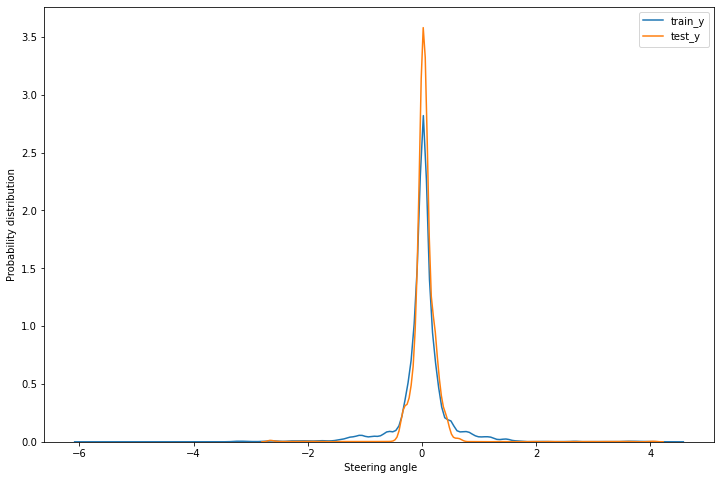

In [4]:
#distribution of train and test y
plt.figure(figsize=(12,8))
sns.distplot(y_train, hist=False, label='train_y')
sns.distplot(y_val, hist=False, label='test_y')
plt.xlabel(' Steering angle')
plt.ylabel('Probability distribution')
plt.legend()
plt.show()

In [5]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(y_train)

print('Test_MSE(MEAN):%f' % np.mean(np.square(y_val-train_mean_y)) )
print('Test_MSE(ZERO):%f' % np.mean(np.square(y_val-0.0)) )

Test_MSE(MEAN):0.090517
Test_MSE(ZERO):0.091768


## 3. Reading images from the path

In [6]:
dataset_path = 'driving_dataset/'
os.path.exists(os.path.join( 'data.txt'))

True

In [7]:
print(len(y_train))
print(len(y_val))

51060
12765


In [8]:
print(len(X[:len(y_train)]))
print(len(X[len(y_train):]))

51060
12765


### 3.1 Checking on single image

In [9]:
X[0]

'driving_dataset/0.jpg'

In [10]:
img = cv2.imread(X[0])
print('Original_size of the image:', img.shape)
print("After taking the last 150 rows i.e lower part of the images where road is present, ",img[-150:].shape)
img = img[-150:]
resized_img = cv2.resize(img, (200,66))  # 200/66 = 455/150 = 3.0303 => we are keeping aspect ratio when we are resizing it
print('shape after resizing it:', resized_img.shape)

Original_size of the image: (256, 455, 3)
After taking the last 150 rows i.e lower part of the images where road is present,  (150, 455, 3)
shape after resizing it: (66, 200, 3)


### 3.2 Doing the same for all images

In [11]:
X_train = []
for i in X[:len(y_train)]:
    img = cv2.imread(i)
    img = img[-150:]
    resized_img = cv2.resize(img, (200,66))
    X_train.append(resized_img)

In [12]:
X_train = np.array(X_train)

In [13]:
import pickle
with open('X_train', 'wb') as f:
    pickle.dump(X_train, f)

In [14]:
print(X_train.shape)

(51060, 66, 200, 3)


In [15]:
X_val = []
for j in X[len(y_train):]:
    img = cv2.imread(i)
    img = img[-150:]
    resized_img = cv2.resize(img, (200,66))
    X_val.append(resized_img)

In [16]:
X_val = np.array(X_val)

In [17]:
import pickle
with open('X_val', 'wb') as f:
    pickle.dump(X_val, f)

In [18]:
print(X_val.shape)

(12765, 66, 200, 3)


### 3.3 Reading from pickle file

In [19]:
with open('X_train', 'rb') as f:
    X_train = pickle.load(f)

In [20]:
with open('X_val', 'rb') as f:
    X_val = pickle.load(f)

In [21]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(51060, 66, 200, 3)
(12765, 66, 200, 3)
(51060,)
(12765,)


## 4. Preparing data for modelling

In [22]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]

print(img_rows, img_cols, channels)

66 200 3


In [23]:
import tensorflow.keras.backend as K

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], channels, img_rows, img_cols).astype('float32')
    X_val = X_val.reshape(X_val.shape[0], channels, img_rows, img_cols).astype('float32')
    img_size = (channels, img_rows, img_cols)
    
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels).astype('float32')
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, channels).astype('float32')
    img_size = (img_rows, img_cols, channels)

In [24]:
X_train = X_train/255.0
X_val = X_val/255.0

In [25]:
print(X_train.shape)
print(X_val.shape)
print(img_size)

(51060, 66, 200, 3)
(12765, 66, 200, 3)
(66, 200, 3)


## 5. Building model from Nvidia Architecture

In [26]:
#https://stackoverflow.com/questions/43915482/how-do-you-create-a-custom-activation-function-with-keras
from tensorflow.keras import backend as k

def custom_activation(x):
    return tf.multiply(tf.math.atan(x), 2) #  arctan range is [-pi/2, pi/2]. so we have to get the angle between [-pi, pi] so we are multiplying by 2

In [28]:
#to refer the model architecture: https://developer.nvidia.com/blog/deep-learning-self-driving-cars/
#to use atan as a activation function refer: https://www.tensorflow.org/api_docs/python/tf/math/atan

img_input = tf.keras.Input(img_size)
x = tf.keras.layers.Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-1')(img_input)
x = tf.keras.layers.Conv2D(filters=36, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-2')(x)
x = tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-3')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-4')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-5')(x)
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.Dense(1164, activation='relu', name='dense_layer-1')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-1')(x)
x = tf.keras.layers.Dense(100, activation='relu', name='dense_layer-2')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-2')(x)
x = tf.keras.layers.Dense(50, activation='relu', name='dense_layer-3')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-3')(x)
x = tf.keras.layers.Dense(10, activation='relu', name='dense_layer-4')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-4')(x)
output = tf.keras.layers.Dense(1, activation=custom_activation, name='output')(x) #note we have used atan to use tan inverse activation

model_1 = tf.keras.models.Model(inputs=img_input, outputs=output, name='model-1')

In [29]:
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 66, 200, 3)]      0         
_________________________________________________________________
conv-1 (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv-2 (Conv2D)              (None, 14, 47, 36)        21636     
_________________________________________________________________
conv-3 (Conv2D)              (None, 5, 22, 48)         43248     
_________________________________________________________________
conv-4 (Conv2D)              (None, 3, 20, 64)         27712     
_________________________________________________________________
conv-5 (Conv2D)              (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0   

## 6. Compiling and fit the model

In [30]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [31]:
batch_size = 64
Epochs = 30

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_file_name = 'my_data/checkpoint/first_run/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [model_checkpoint]

In [33]:
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=Epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2)

Epoch 1/30
798/798 - 175s - loss: 0.2355 - val_loss: 0.1009

Epoch 00001: val_loss improved from inf to 0.10091, saving model to my_data/checkpoint/first_run/weights.01-0.10.hdf5
Epoch 2/30
798/798 - 11s - loss: 0.1737 - val_loss: 0.0909

Epoch 00002: val_loss improved from 0.10091 to 0.09090, saving model to my_data/checkpoint/first_run/weights.02-0.09.hdf5
Epoch 3/30
798/798 - 11s - loss: 0.1171 - val_loss: 0.0934

Epoch 00003: val_loss did not improve from 0.09090
Epoch 4/30
798/798 - 11s - loss: 0.0883 - val_loss: 0.0937

Epoch 00004: val_loss did not improve from 0.09090
Epoch 5/30
798/798 - 11s - loss: 0.0702 - val_loss: 0.0923

Epoch 00005: val_loss did not improve from 0.09090
Epoch 6/30
798/798 - 11s - loss: 0.0594 - val_loss: 0.0935

Epoch 00006: val_loss did not improve from 0.09090
Epoch 7/30
798/798 - 11s - loss: 0.0544 - val_loss: 0.0930

Epoch 00007: val_loss did not improve from 0.09090
Epoch 8/30
798/798 - 11s - loss: 0.0488 - val_loss: 0.1044

Epoch 00008: val_loss di

### 6.1 Model loss plot - using dropout

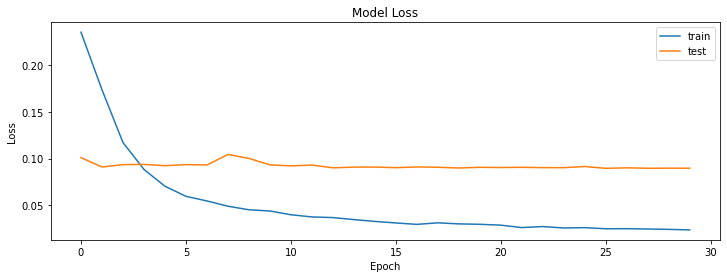

In [34]:
# history plot for accuracy
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

## Summary:
- As we can see from the base model we got Test_MSE(MEAN):0.191127 , Test_MSE(ZERO):0.190891 and here we got 0.1907 as mean_squared_error  with dropout. This makes sense as that most of the time steering angle is 0  and thats why distribution is around with mean as zero. 
- Even after so many epochs we can't reduce mean_squared_error further 

## 7. Using the output prediction 

In [27]:
#https://stackoverflow.com/questions/55779286/valueerror-unknown-activation-function-my-custom-activation-function
best_model_1 = tf.keras.models.load_model('my_data/checkpoint/first_run/weights.26-0.09.hdf5', 
                                          custom_objects={'custom_activation':custom_activation})
all_pred = []

for i in X_val[1000:2000]:
    i = cv2.resize(i, (200,66))
    i = i/255.0
    i = np.expand_dims(i, axis=0)
    prediction = best_model_1.predict(i)
    all_pred.extend(prediction[0])

In [28]:
(set(all_pred))

{-0.7811845}

In [29]:
len(set(y_val[1000:2000]))

178

### 7.1 Making the video using the images we have so that we can rotate the steering using the video

In [30]:
print(os.path.exists(X[0]))
print(type(X[0]))

True
<class 'str'>


In [ ]:
#https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/

#we have X which is a list contains the path of each image
image_array = []
for i in X:
    img = cv2.imread(i)
    image_array.append(img)

out = cv2.VideoWriter('my_data/Self_Driving_Car.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, (img.shape[1], img.shape[0]))
for j in range(len(image_array)):
    out.write(image_array[j])
out.release()

### 7.2 Rotate the steering as per the prediction

In [ ]:
#to rotate the steering image refer https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
#steering_image
import scipy
model_1 = tf.keras.models.load_model('my_data/checkpoint/first_run/weights.20-0.19.hdf5', 
                                          custom_objects={'custom_activation':custom_activation})
steering_img = cv2.imread('steering_wheel_image.jpg')
rows, cols = steering_img.shape[0], steering_img.shape[1]

cap = cv2.VideoCapture('my_data/Self_Driving_Car.avi')

smoothed_angle = 0
while True:
    ret, frame = cap.read()
    resized_frame = cv2.resize(frame, (200,66))
    resized_frame = resized_frame/255.0
    resized_frame = np.expand_dims(resized_frame,axis=0)
    degrees = (model_1.predict(resized_frame) * 180)/scipy.pi  #to convert the radians to degrees
    cv2.imshow('frame', frame)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0/2 * pow(abs(degrees - smoothed_angle), 2.0/3.0) * (degrees-smoothed_angle) / abs(degrees-smoothed_angle)
    degrees=float(degrees)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), -degrees, 1)
    dst = cv2.warpAffine(steering_img, M, (cols,rows))
    cv2.imshow('steering_wheel', dst)
    
    if cv2.waitKey(1)==27:
        break
        
cv2.destroyAllWindows()
cap.release()

- split ---> 70%training and 30% testing
- adam optimizer ---> learning_rate = 0.001
- dropout ---> 0.5
- activation --> 'linear' instead of atan

In [42]:
#reading the data set from data.txt

dataset_path = 'driving_dataset/'
training_path = os.path.join(dataset_path, 'data.txt')

split = 0.7
X = []
y = []

#islice(text, start, stop, LIMIT) --> ('ABCDEF', 2, None) --> 'C D E F'  -->https://docs.python.org/2/library/itertools.html
with open(training_path) as f:
    for line in islice(f, None):
        path, angle = line.strip().split()
        full_path = os.path.join(dataset_path, path)
        X.append(full_path)
        y.append(float(angle)*pi/180)

y = np.array(y)
print('Finished processing')

#Split it with 70/30
split_index = int(len(y)*0.7)
y_train = y[:split_index]
y_val = y[split_index:]

Finished processing


### 8.1 Base Model

/home/varun/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/varun/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


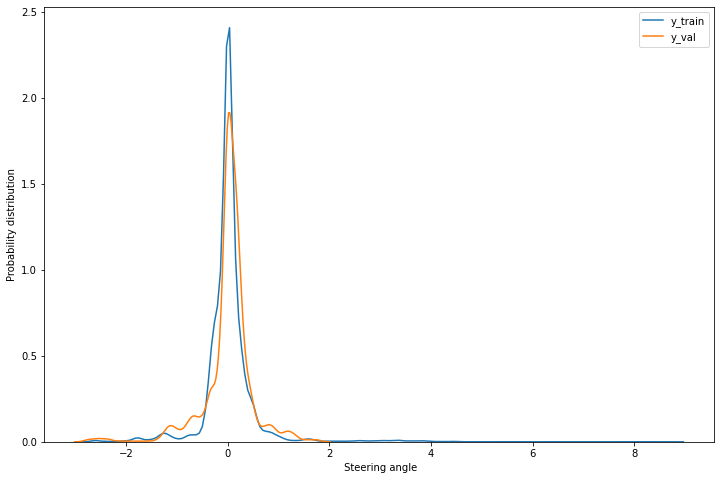

In [43]:
#distribution of train and test y
plt.figure(figsize=(12,8))
sns.distplot(y_train, hist=False, label='y_train')
sns.distplot(y_val, hist=False, label='y_val')
plt.xlabel(' Steering angle')
plt.ylabel('Probability distribution')
plt.legend()
plt.show()

In [44]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(y_train)

print('Test_MSE(MEAN):%f' % np.mean(np.square(y_val-train_mean_y)) )
print('Test_MSE(ZERO):%f' % np.mean(np.square(y_val-0.0)) )

Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


### 8.2. Reading images from the path

In [45]:
dataset_path = 'driving_dataset/'
os.path.exists(os.path.join(dataset_path, 'data.txt'))

True

In [46]:
print(len(X[:len(y_train)]))
print(len(X[len(y_train):]))

31784
13622


#### 8.2.1 Checking on single image

In [47]:
X[0]

'driving_dataset/0.jpg'

In [48]:
img = cv2.imread(X[0])
print('Original_size of the image:', img.shape)
print("After taking the last 150 rows i.e lower part of the images where road is present, ",img[-150:].shape)
img = img[-150:]
resized_img = cv2.resize(img, (200,66))  # 200/66 = 455/150 = 3.0303 => we are keeping aspect ratio when we are resizing it
print('shape after resizing it:', resized_img.shape)

Original_size of the image: (256, 455, 3)
After taking the last 150 rows i.e lower part of the images where road is present,  (150, 455, 3)
shape after resizing it: (66, 200, 3)


#### 8.2..2 Doing the same for all images

In [49]:
X_train = []
for i in X[:len(y_train)]:
    img = cv2.imread(i)
    img = img[-150:]
    resized_img = cv2.resize(img, (200,66))
    X_train.append(resized_img)

In [50]:
X_train = np.array(X_train)

In [51]:
import pickle
with open('assign_train', 'wb') as f:
    pickle.dump(X_train, f)

In [52]:
print(X_train.shape)

(31784, 66, 200, 3)


In [53]:
X_val = []
for j in X[len(y_train):]:
    img = cv2.imread(i)
    img = img[-150:]
    resized_img = cv2.resize(img, (200,66))
    X_val.append(resized_img)

In [54]:
X_val = np.array(X_val)

In [55]:
import pickle
with open('assign_val', 'wb') as f:
    pickle.dump(X_val, f)

In [56]:
print(X_val.shape)

(13622, 66, 200, 3)


### 8.3 Reading from pickle file

In [58]:
with open('assign_train', 'rb') as f:
    X_train = pickle.load(f)

In [59]:
with open('assign_val', 'rb') as f:
    X_val = pickle.load(f)

In [60]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(31784, 66, 200, 3)
(13622, 66, 200, 3)
(31784,)
(13622,)


### 8.4. Preparing data for modelling

In [61]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]

In [62]:
import tensorflow.keras.backend as K

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], channels, img_rows, img_cols).astype('float32')
    X_val = X_val.reshape(X_val.shape[0], channels, img_rows, img_cols).astype('float32')
    img_size = (channels, img_rows, img_cols)
    
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels).astype('float32')
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, channels).astype('float32')
    img_size = (img_rows, img_cols, channels)

In [63]:
X_train = X_train/255.0
X_val = X_val/255.0

In [64]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(img_size)

(31784, 66, 200, 3)
(31784,)
(13622, 66, 200, 3)
(13622,)
(66, 200, 3)


### 8.5. Building model from Nvidia Architecture

In [65]:
import tensorflow as tf

In [66]:
#https://developer.nvidia.com/blog/deep-learning-self-driving-cars/

img_input = tf.keras.Input(img_size)
x = tf.keras.layers.Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-1')(img_input)
x = tf.keras.layers.Conv2D(filters=36, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-2')(x)
x = tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-3')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-4')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-5')(x)
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.Dense(1164, activation='relu', name='dense_layer-1')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout-1')(x)
x = tf.keras.layers.Dense(100, activation='relu', name='dense_layer-2')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout-2')(x)
x = tf.keras.layers.Dense(50, activation='relu', name='dense_layer-3')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout-3')(x)
x = tf.keras.layers.Dense(10, activation='relu', name='dense_layer-4')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout-4')(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, name='output')(x) #note we have used atan to use tan inverse activation

model_2 = tf.keras.models.Model(inputs=img_input, outputs=output, name='model-2')

In [67]:
model_2.summary()

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 66, 200, 3)]      0         
_________________________________________________________________
conv-1 (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv-2 (Conv2D)              (None, 14, 47, 36)        21636     
_________________________________________________________________
conv-3 (Conv2D)              (None, 5, 22, 48)         43248     
_________________________________________________________________
conv-4 (Conv2D)              (None, 3, 20, 64)         27712     
_________________________________________________________________
conv-5 (Conv2D)              (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0   

### 8.6 Compiling and fit the model

In [68]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [69]:
batch_size = 64
Epochs = 30

In [72]:
from datetime import datetime
from tensorflow.keras.callbacks import  ModelCheckpoint

checkpoint_file_name = 'my_data/checkpoint/assign/July_01-weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [model_checkpoint]

In [73]:
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=Epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2)

Epoch 1/30
497/497 - 10s - loss: 0.3130 - val_loss: 0.2410

Epoch 00001: val_loss improved from inf to 0.24103, saving model to my_data/checkpoint/assign/July_01-weights.01-0.24.hdf5
Epoch 2/30
497/497 - 10s - loss: 0.3077 - val_loss: 0.2411

Epoch 00002: val_loss did not improve from 0.24103
Epoch 3/30
497/497 - 10s - loss: 0.2937 - val_loss: 0.2409

Epoch 00003: val_loss improved from 0.24103 to 0.24094, saving model to my_data/checkpoint/assign/July_01-weights.03-0.24.hdf5
Epoch 4/30
497/497 - 10s - loss: 0.2665 - val_loss: 0.2419

Epoch 00004: val_loss did not improve from 0.24094
Epoch 5/30
497/497 - 10s - loss: 0.2479 - val_loss: 0.2470

Epoch 00005: val_loss did not improve from 0.24094
Epoch 6/30
497/497 - 10s - loss: 0.2269 - val_loss: 0.2583

Epoch 00006: val_loss did not improve from 0.24094
Epoch 7/30
497/497 - 10s - loss: 0.2116 - val_loss: 0.2517

Epoch 00007: val_loss did not improve from 0.24094
Epoch 8/30
497/497 - 6s - loss: 0.2059 - val_loss: 0.2462

Epoch 00008: val

## Summary:
- As we can see from the base model we got test_mse with mean as a prediction we got 0.241561 and Test_MSE(ZERO):0.241107 and here we got 0.24098 as mean_squared_error with dropout. This makes our model works better than our base model. 
- Even after so many epochs we can't reduce mean_squared_error further

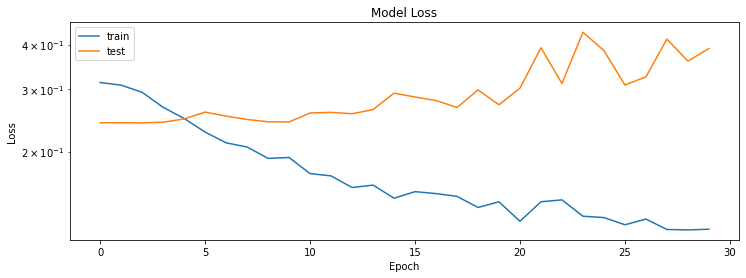

In [74]:
# history plot for accuracy
plt.figure(figsize=(12,4))
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend(["train", "test"], loc="upper left")
plt.show() 

### 8.7 Predict using best model

In [76]:
best_model_2 = tf.keras.models.load_model('my_data/checkpoint/assign/July_01-weights.03-0.24.hdf5')

all_pred = []
for i in X_val[1000:2000]:
    i = cv2.resize(i, (200,66))
    i = i/255.0
    i = np.expand_dims(i, axis=0)
    prediction = best_model_2.predict(i)
    all_pred.extend(prediction[0])

In [77]:
set(all_pred)

{0.034316905}

In [78]:
len(set(y_val[1000:2000]))

518

### 8.8 Using the output prediction 

In [ ]:
#to rotate the steering image refer https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
#steering_image
import scipy
model_1 = tf.keras.models.load_model('my_data/checkpoint/assign/July_01-weights.03-0.24.hdf5', 
                                          custom_objects={'custom_activation':custom_activation})
steering_img = cv2.imread('steering_wheel_image.jpg')
rows, cols = steering_img.shape[0], steering_img.shape[1]

cap = cv2.VideoCapture('my_data/Self_Driving_Car.avi')

smoothed_angle = 0
while True:
    ret, frame = cap.read()
    resized_frame = cv2.resize(frame, (200,66))
    resized_frame = resized_frame/255.0
    resized_frame = np.expand_dims(resized_frame,axis=0)
    degrees = (model_1.predict(resized_frame) * 180)/scipy.pi  #to convert the radians to degrees
    cv2.imshow('frame', frame)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0/2 * pow(abs(degrees - smoothed_angle), 2.0/3.0) * (degrees-smoothed_angle) / abs(degrees-smoothed_angle)
    degrees=float(degrees)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), -degrees, 1)
    dst = cv2.warpAffine(steering_img, M, (cols,rows))
    cv2.imshow('steering_wheel', dst)
    
    if cv2.waitKey(1)==27:
        break
        
cv2.destroyAllWindows()
cap.release()